# DATA SCIENCE & AI (FIAP MBA) - Sabrina Otoni da Silva - 2023

## Projeto nº 12

Será utilizado os dados referentes a um estudo de caso-controle realizado no Setor de Anatomia e Patologia do Hospital Heliópolis em São Paulo, no período de 1970 a 1982 (canc3.csv). Um total de 175 pacientes com processo infecioso pulmonar atendido no hospital no período acima foi classificado segundo as seguintes variáveis: tipo, tipo de tumor (1: maligno, 0: benigno); IDADE, idade em anos; SEXO (0:masculino, 1: feminino); HL, intensidade da célula histócitos-linfócitos (1:ausente, 2: discreta, 3: moderada, 4: intensa) e FF, intensidade da célula fibrose-frouxa (1:ausente, 2: discreta, 3: moderada, 4: intensa).

* Atividades:

    Fazer inicialmente uma análise descritiva dos dados.

    Fazer um modelo de regressão logística.

    Fazer um modelo usando árvore de decisão.

    Comparar os dois modelos usando a métrica mais apropriada.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('Bases/canc3.csv', delimiter=';')
df.head()

,tipo,idade,sexo,hl,ff
0,0,26,1,3,1
1,0,21,1,3,1
2,0,45,1,3,3
3,0,19,2,4,3
4,0,16,2,4,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   tipo    175 non-null    int64
 1   idade   175 non-null    int64
 2   sexo    175 non-null    int64
 3   hl      175 non-null    int64
 4   ff      175 non-null    int64
dtypes: int64(5)
memory usage: 7.0 KB


In [5]:
df.describe()

,tipo,idade,sexo,hl,ff
count,175.000000,175.000000,175.000000,175.000000,175.000000
mean,0.405714,47.702857,1.280000,2.605714,1.891429
std,0.492439,18.206439,0.450287,0.702190,0.893582
min,0.000000,15.000000,1.000000,1.000000,1.000000
25%,0.000000,30.000000,1.000000,2.000000,1.000000
50%,0.000000,50.000000,1.000000,3.000000,2.000000
75%,1.000000,61.000000,2.000000,3.000000,3.000000
max,1.000000,87.000000,2.000000,4.000000,4.000000


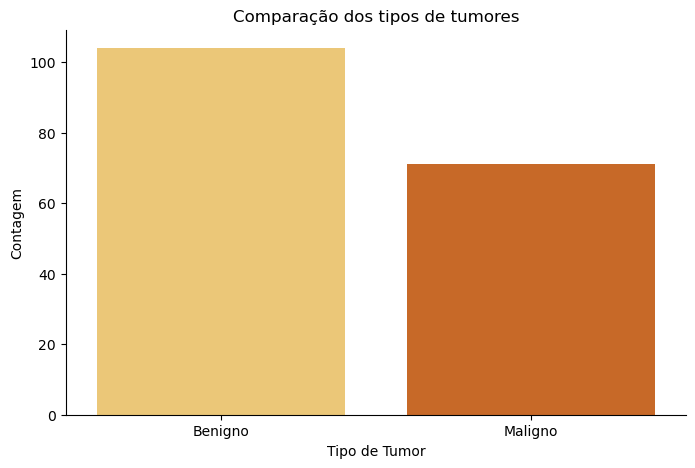

In [6]:
value_counts = df['tipo'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='YlOrBr')
plt.xticks(value_counts.index, ['Benigno', 'Maligno'])
plt.xlabel('Tipo de Tumor')
plt.ylabel('Contagem')
plt.title('Comparação dos tipos de tumores')
sns.despine()
plt.show()

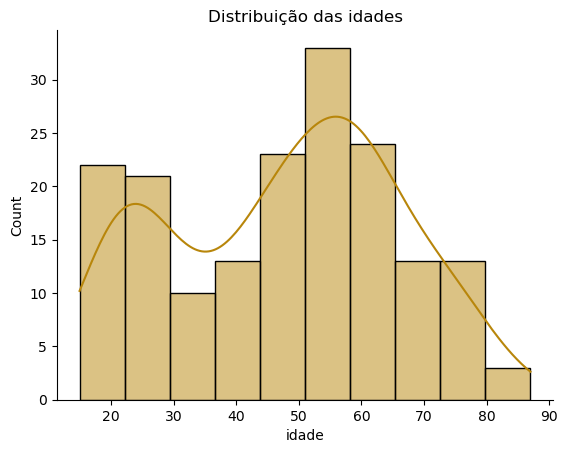

In [7]:
sns.histplot(x=df['idade'], bins=10, color='darkgoldenrod', kde=True)
plt.title('Distribuição das idades')
sns.despine()
plt.show()

In [8]:
intervalos_idade = [i for i in range(15, 100, 10)]
df['idade_intervalo'] = pd.cut(df['idade'], bins=intervalos_idade, right=False)
df.groupby(['idade_intervalo', 'tipo']).size().unstack(fill_value=0)

tipo,0,1
idade_intervalo,,
"[15, 25)",30,2
"[25, 35)",17,2
"[35, 45)",14,4
"[45, 55)",20,11
"[55, 65)",13,31
"[65, 75)",4,15
"[75, 85)",5,6
"[85, 95)",1,0


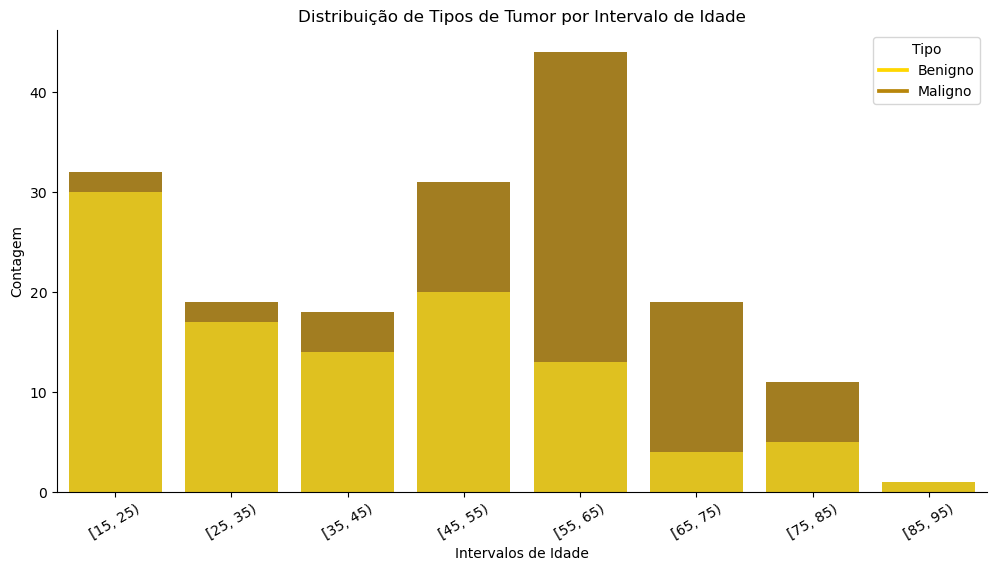

In [9]:
contagem_por_intervalo = df.groupby(['idade_intervalo', 'tipo']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

sns.barplot(data=contagem_por_intervalo.reset_index(), x='idade_intervalo', y=0, color='gold', label='Benigno')
sns.barplot(data=contagem_por_intervalo.reset_index(), x='idade_intervalo', y=1, color='darkgoldenrod', bottom=contagem_por_intervalo[0], label='Maligno')

plt.xlabel('Intervalos de Idade')
plt.ylabel('Contagem')
plt.title('Distribuição de Tipos de Tumor por Intervalo de Idade')
plt.xticks(rotation=30)

legenda = plt.legend(title='Tipo', labels=['Benigno', 'Maligno'], loc='upper right')
cores=['gold', 'darkgoldenrod']
for i, tipo in enumerate(['Benigno', 'Maligno']):
    legenda.get_lines()[i].set_color(cores[i])

sns.despine()

plt.show()

In [10]:
df['sexo'] = df['sexo'].apply(lambda x: 0 if x == 1 else 1)

In [11]:
df.groupby(['sexo', 'tipo']).size().unstack(fill_value=0)

tipo,0,1
sexo,,
0,78,48
1,26,23


<Figure size 800x600 with 0 Axes>

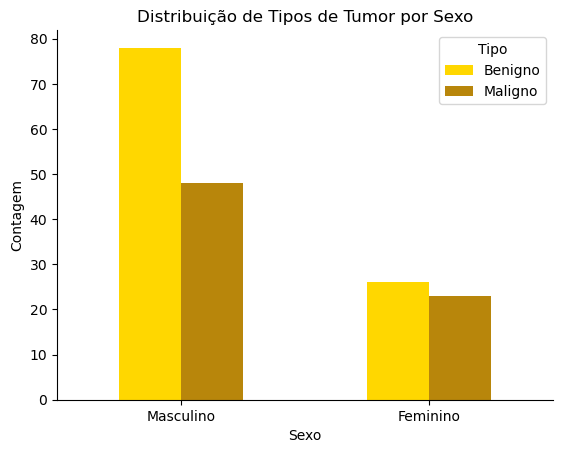

In [12]:
plt.figure(figsize=(8, 6))

contagem_por_sexo = df.groupby(['sexo', 'tipo']).size().unstack(fill_value=0)
contagem_por_sexo.plot(kind='bar', color=['gold', 'darkgoldenrod'])

plt.xlabel('Sexo')
plt.ylabel('Contagem')
plt.title('Distribuição de Tipos de Tumor por Sexo')

plt.legend(title='Tipo', labels=['Benigno', 'Maligno'])

plt.xticks([0, 1], ['Masculino', 'Feminino'], rotation=0)

sns.despine()

plt.show()

In [13]:
df.head()

,tipo,idade,sexo,hl,ff,idade_intervalo
0,0,26,0,3,1,"[25, 35)"
1,0,21,0,3,1,"[15, 25)"
2,0,45,0,3,3,"[45, 55)"
3,0,19,1,4,3,"[15, 25)"
4,0,16,1,4,3,"[15, 25)"


<Figure size 1200x600 with 0 Axes>

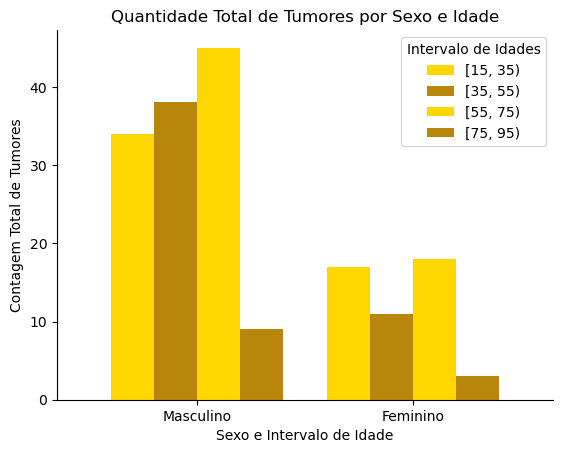

In [14]:
intervalos_idade = [i for i in range(15, 100, 20)]
df['idade_intervalo'] = pd.cut(df['idade'], bins=intervalos_idade, right=False)

plt.figure(figsize=(12, 6))

contagem_por_sexo_idade = df.groupby(['sexo', 'idade_intervalo']).size().unstack(fill_value=0)
contagem_por_sexo_idade.plot(kind='bar', color=['gold', 'darkgoldenrod'], width=0.8)


plt.xlabel('Sexo e Intervalo de Idade')
plt.ylabel('Contagem Total de Tumores')
plt.title('Quantidade Total de Tumores por Sexo e Idade')

plt.xticks([0, 1], ['Masculino', 'Feminino'], rotation=0)

plt.legend(title='Idades').get_title().set_text('Intervalo de Idades')

sns.despine()
plt.show()

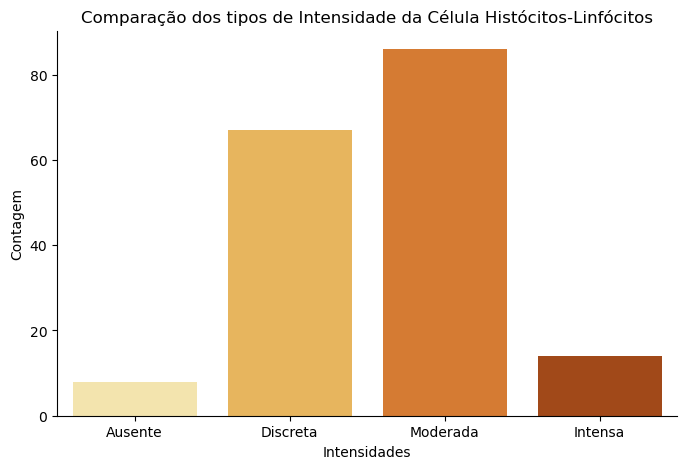

In [15]:
value_counts = df['hl'].value_counts().sort_index()

mapeamento = {
    1: 'Ausente',
    2: 'Discreta',
    3: 'Moderada',
    4: 'Intensa',
}

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette='YlOrBr')
plt.xlabel('Intensidades')
plt.ylabel('Contagem')
plt.title('Comparação dos tipos de Intensidade da Célula Histócitos-Linfócitos')

ax.set_xticklabels([mapeamento[val] for val in value_counts.index])

sns.despine()
plt.show()

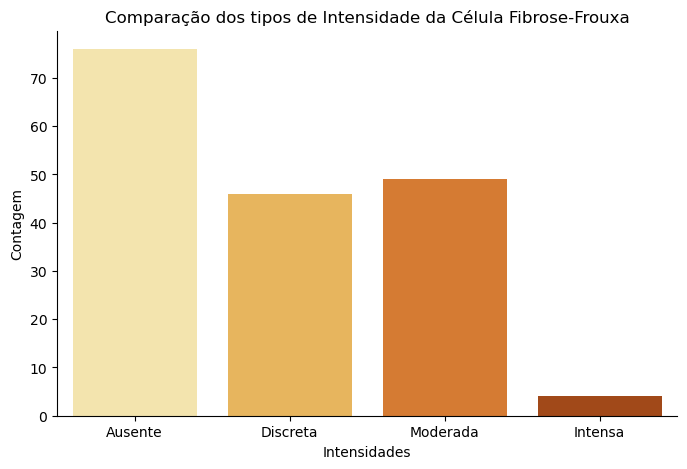

In [16]:
value_counts = df['ff'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette='YlOrBr')
plt.xlabel('Intensidades')
plt.ylabel('Contagem')
plt.title('Comparação dos tipos de Intensidade da Célula Fibrose-Frouxa')

ax.set_xticklabels([mapeamento[val] for val in value_counts.index])

sns.despine()
plt.show()

In [17]:
df.drop('idade_intervalo', axis=1, inplace=True)

In [18]:
df.head()

,tipo,idade,sexo,hl,ff
0,0,26,0,3,1
1,0,21,0,3,1
2,0,45,0,3,3
3,0,19,1,4,3
4,0,16,1,4,3


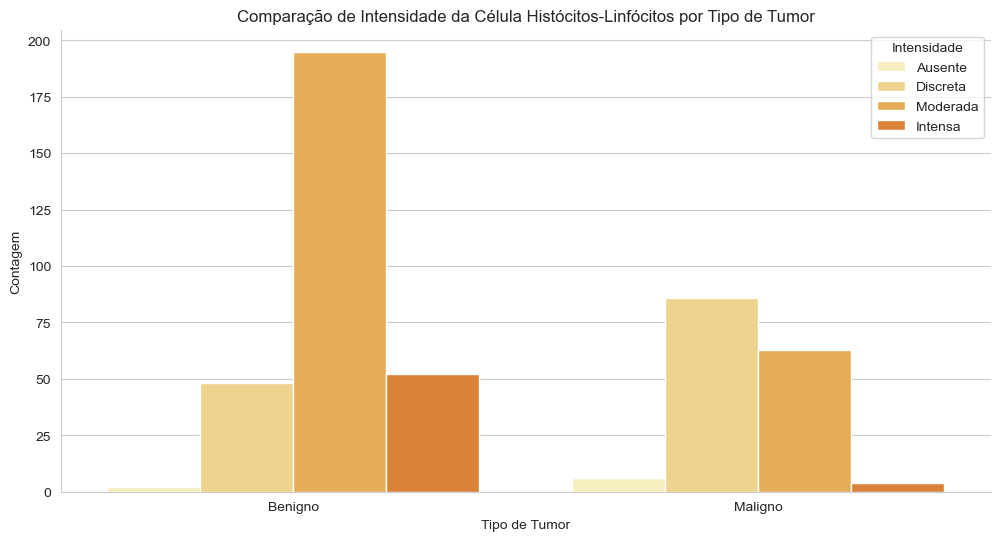

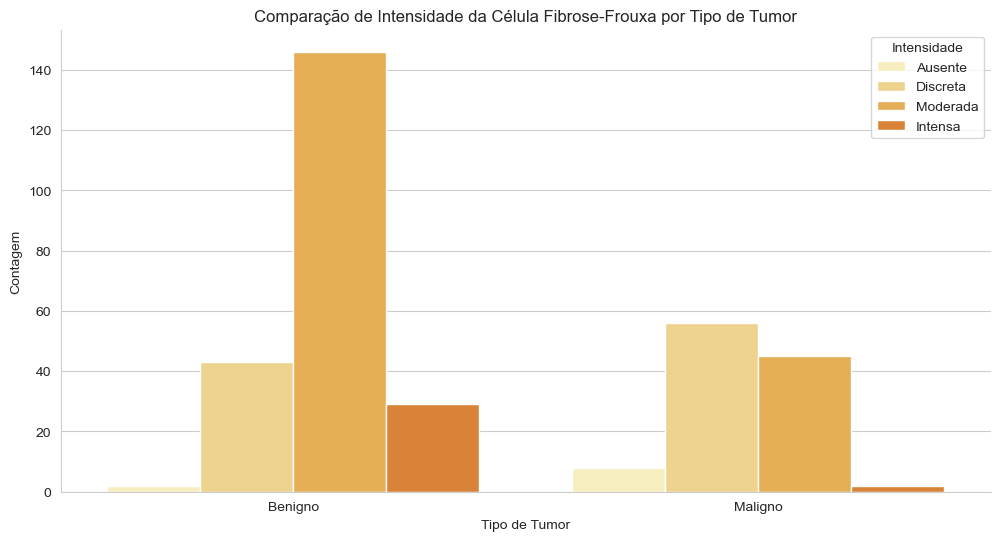

In [19]:
plt.figure(figsize=(12, 6))
sns.set_palette("YlOrBr")
sns.set_style("whitegrid")
ax = sns.barplot(x='tipo', y='hl', data=df, errorbar=None, estimator=sum, hue='hl', hue_order=[1, 2, 3, 4])
plt.xlabel('Tipo de Tumor')
plt.ylabel('Contagem')
plt.title('Comparação de Intensidade da Célula Histócitos-Linfócitos por Tipo de Tumor')

plt.legend(title='Intensidade', loc='upper right', labels=[mapeamento[i] for i in range(1, 5)])

ax.set_xticklabels(['Benigno', 'Maligno'])

sns.despine()
plt.show()

plt.figure(figsize=(12, 6))
sns.set_palette("YlOrBr")
sns.set_style("whitegrid")
ax = sns.barplot(x='tipo', y='ff', data=df, errorbar=None, estimator=sum, hue='hl', hue_order=[1, 2, 3, 4])
plt.xlabel('Tipo de Tumor')
plt.ylabel('Contagem')
plt.title('Comparação de Intensidade da Célula Fibrose-Frouxa por Tipo de Tumor')

plt.legend(title='Intensidade', loc='upper right', labels=[mapeamento[i] for i in range(1, 5)])

ax.set_xticklabels(['Benigno', 'Maligno'])

sns.despine()
plt.show()

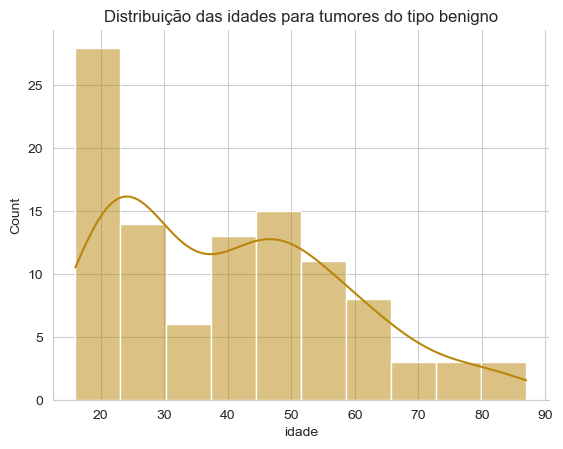

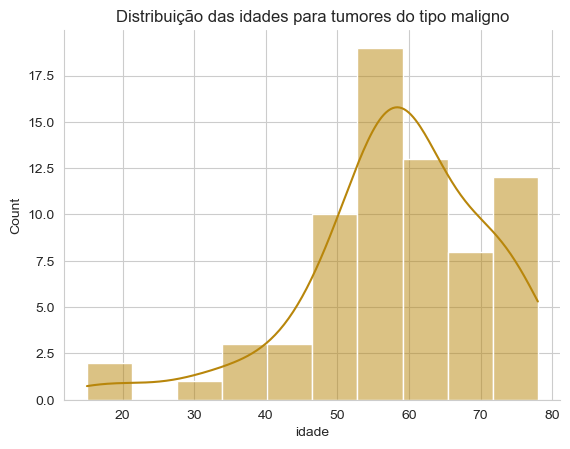

In [20]:
sns.histplot(x=df.loc[df['tipo'] == 0, 'idade'], bins=10, color='darkgoldenrod', kde=True)
plt.title('Distribuição das idades para tumores do tipo benigno')
sns.despine()
plt.show()

sns.histplot(x=df.loc[df['tipo'] == 1, 'idade'], bins=10, color='darkgoldenrod', kde=True)
plt.title('Distribuição das idades para tumores do tipo maligno')
sns.despine()
plt.show()

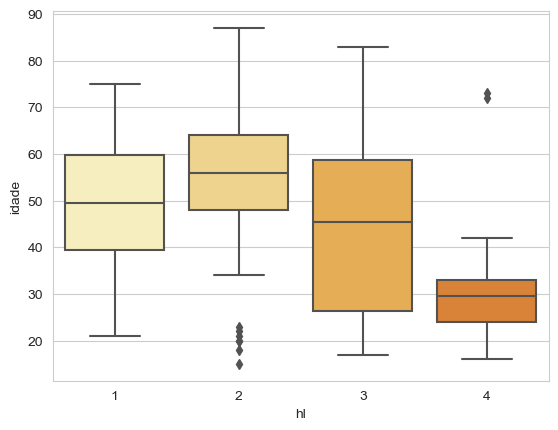

In [21]:
sns.boxplot(data=df, x='hl', y='idade')
plt.show()

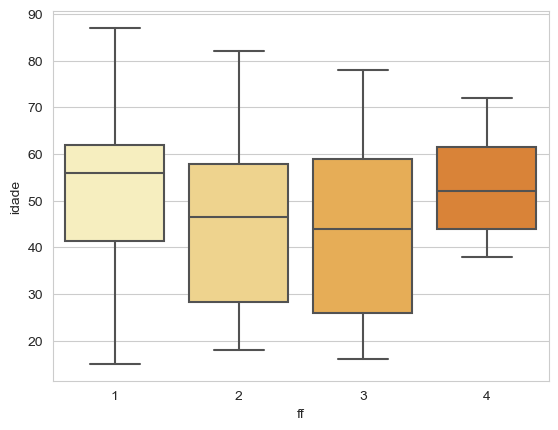

In [22]:
sns.boxplot(data=df, x='ff', y='idade')
plt.show()

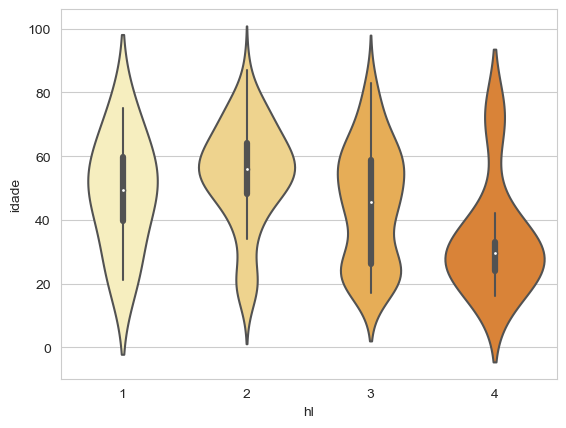

In [23]:
sns.violinplot(data=df, x='hl', y='idade')
plt.show()

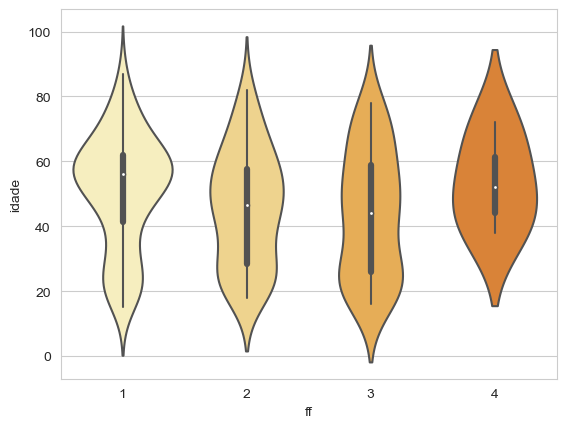

In [24]:
sns.violinplot(data=df, x='ff', y='idade')
plt.show()

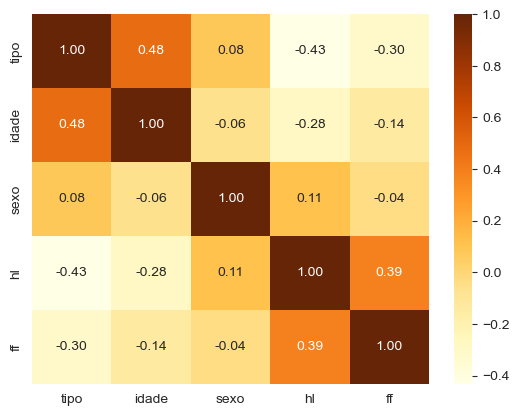

In [25]:
sns.heatmap(df.corr(), cmap='YlOrBr', annot=True, fmt='.2f')
plt.show()

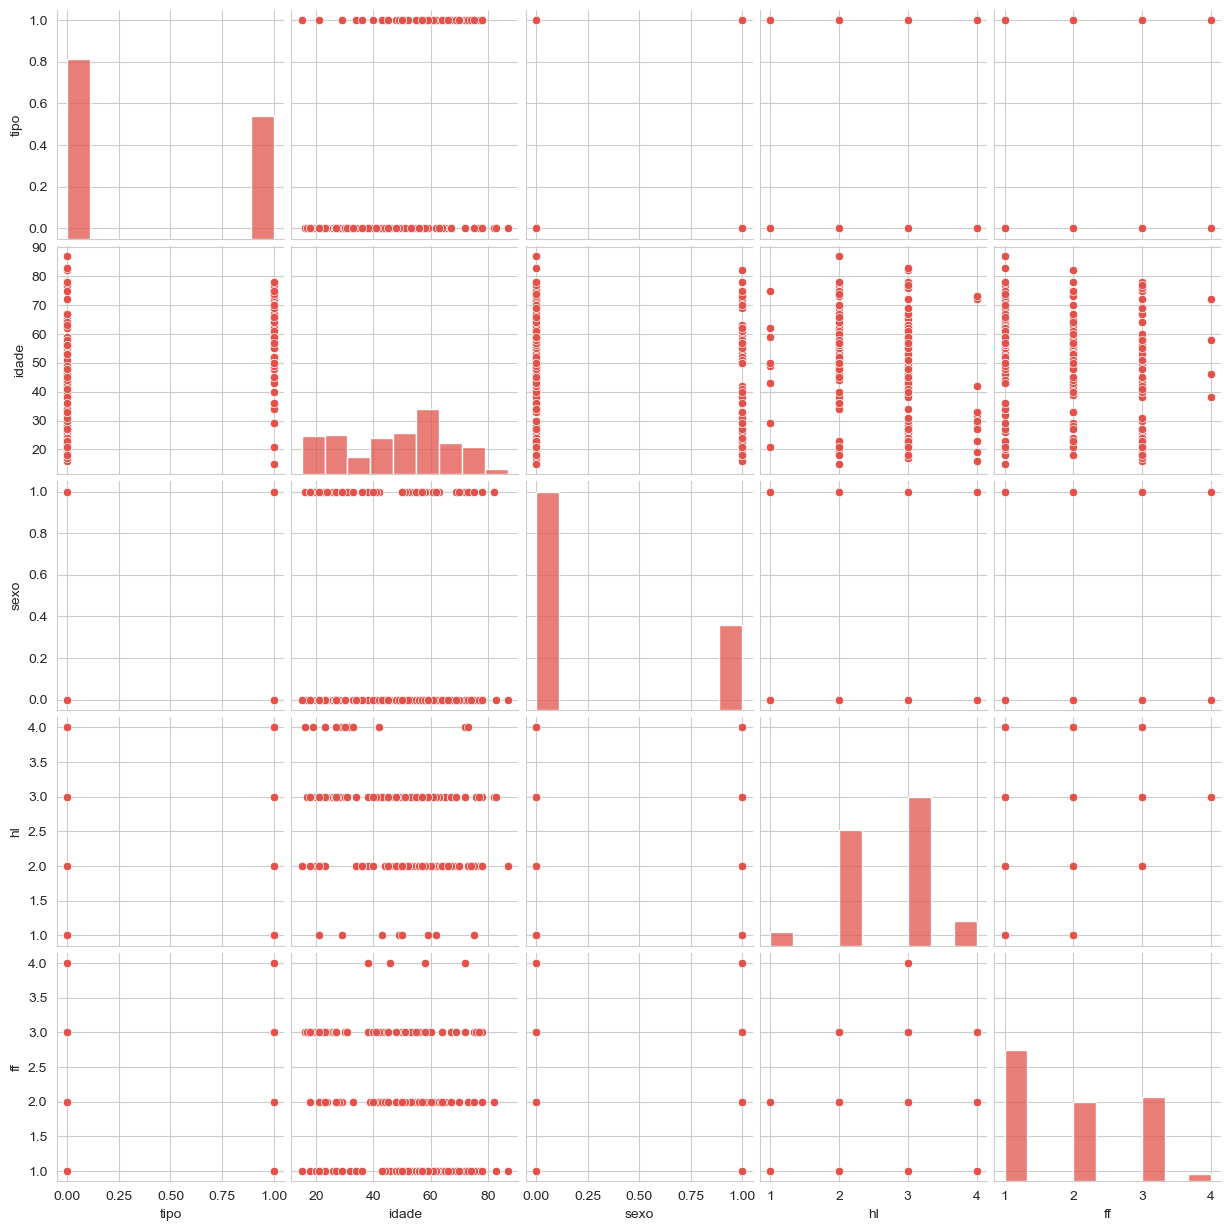

In [26]:
sns.set_palette("Spectral")
sns.pairplot(df)
plt.show()

In [27]:
df.drop('hl', axis=1, inplace=True)

In [28]:
df.head()

,tipo,idade,sexo,ff
0,0,26,0,1
1,0,21,0,1
2,0,45,0,3
3,0,19,1,3
4,0,16,1,3


In [29]:
def evaluate_model_LR(cv):

  X = df.drop('tipo', axis=1)
  y = df['tipo']

  model = LogisticRegression()

  scores = cross_val_score(model, X, y, cv=cv)

  return scores

In [30]:
for k in range(2,11):
  cv = KFold(n_splits=k, shuffle=True)
  print(f'-> folds={k}, ', evaluate_model_LR(cv))

-> folds=2,  [0.73863636 0.79310345]
-> folds=3,  [0.6779661  0.81034483 0.79310345]
-> folds=4,  [0.65909091 0.65909091 0.86363636 0.8372093 ]
-> folds=5,  [0.74285714 0.77142857 0.77142857 0.71428571 0.8       ]
-> folds=6,  [0.63333333 0.68965517 0.75862069 0.72413793 0.82758621 0.89655172]
-> folds=7,  [0.72 0.76 0.84 0.72 0.84 0.72 0.68]
-> folds=8,  [0.68181818 0.63636364 0.72727273 0.72727273 0.81818182 0.77272727
 0.68181818 0.85714286]
-> folds=9,  [0.7        0.65       0.75       0.7        0.73684211 0.78947368
 0.73684211 0.84210526 0.84210526]
-> folds=10,  [0.88888889 0.66666667 0.66666667 0.94444444 0.72222222 0.70588235
 0.82352941 0.70588235 0.88235294 0.58823529]


In [31]:
cv_prediction_LR = cross_val_predict(LogisticRegression(), df.drop('tipo', axis=1), df['tipo'], cv=10)

In [32]:
print(accuracy_score(df['tipo'], cv_prediction_LR))

0.7428571428571429


In [33]:
confusion_matrix_LR = confusion_matrix(df['tipo'], cv_prediction_LR)
confusion_matrix_LR

array([[83, 21],
       [24, 47]], dtype=int64)

In [34]:
print(classification_report(df['tipo'], cv_prediction_LR))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       104
           1       0.69      0.66      0.68        71

    accuracy                           0.74       175
   macro avg       0.73      0.73      0.73       175
weighted avg       0.74      0.74      0.74       175



In [35]:
def evaluate_model_DT(cv):

  X = df.drop('tipo', axis=1)
  y = df['tipo']

  model = DecisionTreeClassifier()

  scores = cross_val_score(model, X, y, cv=cv)

  return scores

In [36]:
for k in range(2,11):
  cv = KFold(n_splits=k, shuffle=True)
  print(f'-> folds={k}, ', evaluate_model_DT(cv))

-> folds=2,  [0.69318182 0.67816092]
-> folds=3,  [0.66101695 0.65517241 0.74137931]
-> folds=4,  [0.59090909 0.56818182 0.59090909 0.8372093 ]
-> folds=5,  [0.77142857 0.71428571 0.65714286 0.74285714 0.62857143]
-> folds=6,  [0.73333333 0.75862069 0.68965517 0.75862069 0.5862069  0.5862069 ]


-> folds=7,  [0.56 0.64 0.64 0.76 0.6  0.8  0.64]
-> folds=8,  [0.68181818 0.68181818 0.77272727 0.72727273 0.5        0.72727273
 0.81818182 0.61904762]
-> folds=9,  [0.65       0.6        0.75       0.8        0.68421053 0.57894737
 0.73684211 0.68421053 0.63157895]
-> folds=10,  [0.61111111 0.72222222 0.72222222 0.88888889 0.61111111 0.64705882
 0.64705882 0.41176471 0.58823529 0.64705882]


In [37]:
cv_prediction_DT = cross_val_predict(DecisionTreeClassifier(), df.drop('tipo', axis=1), df['tipo'], cv=10)

In [38]:
print(accuracy_score(df['tipo'], cv_prediction_DT))

0.6742857142857143


In [39]:
confusion_matrix_DT = confusion_matrix(df['tipo'], cv_prediction_DT)
confusion_matrix_DT

array([[80, 24],
       [33, 38]], dtype=int64)

In [40]:
print(classification_report(df['tipo'], cv_prediction_DT))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       104
           1       0.61      0.54      0.57        71

    accuracy                           0.67       175
   macro avg       0.66      0.65      0.65       175
weighted avg       0.67      0.67      0.67       175

